In [1]:
'''
FETCH NEURON SPIKE DATA FROM MAT FILE
'''

import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy import io
refractory_period=1
def get_data():
    file2 = 'C:/Users/abish/Documents/Workspace/PrinciplesofAIProject/spikeSorting/Simulator/Simulator/C_Difficult2_noise005.mat'
    data1 = io.loadmat(file2)
    df_spikeclass = pd.DataFrame(np.transpose(data1['spike_class']), columns=['spike_class'])
    df_spiketimes = pd.DataFrame(np.transpose(data1['spike_times']), columns=['spike_times'])
    df_overlapdata = pd.DataFrame(np.transpose(data1['OVERLAP_DATA']), columns=['OVERLAP_DATA'])
    df_samplinginterval = pd.DataFrame(np.transpose(data1['samplingInterval']), columns=['samplingInterval'])
    df1 = pd.DataFrame(np.transpose(data1['data']), columns=['data'])
    pd.set_option('display.max_columns', None)
    
    spike_class_arr = df_spikeclass.as_matrix()
    spike_class = np.zeros((3,np.array(spike_class_arr[0,0]).shape[1]))
    spike_class[0] = np.array(spike_class_arr[0,0])
    spike_class[1] = np.array(spike_class_arr[1,0])
    spike_class[2] = np.array(spike_class_arr[2,0])
    spike_times = np.array(df_spiketimes.loc[0][0]).flatten()
    # print(spike_class.shape)
    import collections
    counter_0=collections.Counter(spike_class[0])
    counter_1=collections.Counter(spike_class[1])
    counter_2=collections.Counter(spike_class[2])
    # print( 'SC0 : {} SC1 : {} SC2 : {}'.format(counter_0,counter_1,counter_2) )
    
    sampling_interval = float(df_samplinginterval.values)
    df2 = df1.head(1000000)
    df3 = df1.loc[1000000:]
    return (df2,df3,sampling_interval,spike_class)



In [2]:
def band_pass_filter(data, sampling_interval, fs, lowcut, highcut):
    # Sample rate and desired cutoff frequencies (in Hz).
    #fs = 24000.0
    #lowcut = 300.0
    #highcut = 3000.0
    
    # Butterworth second-order filter
    order = 2
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    filtered_data = signal.lfilter(b, a, data)

    T = sampling_interval
    print('Sampling Interval - {}'.format(T))
    nsamples = T * raw_data.size
    t = np.linspace(0,nsamples,num=fs,endpoint=True)
    plt.plot(t, data, label='Noisy signal')
    plt.show()
    plt.plot(t, filtered_data, label='Filtered signal')
    plt.show()
    return filtered_data
    

Sampling Interval - 0.041666666666666664


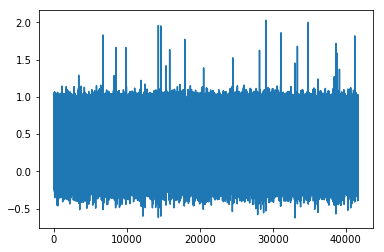

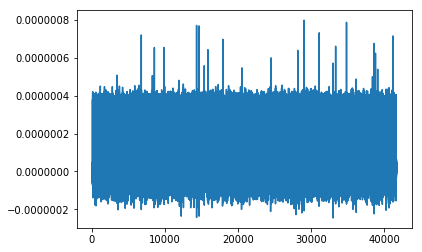

Sampling Interval - 0.041666666666666664


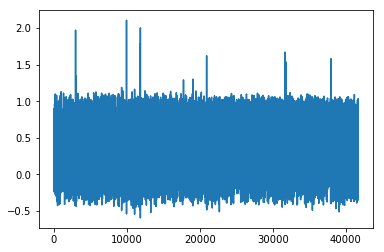

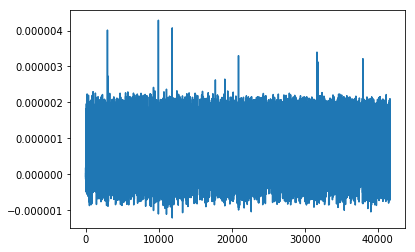

In [3]:
# Raw data had 1.44 million data points which could not be processed at a time
raw_data,raw_data_c,sampling_interval,spike_class = get_data()

# data for first 1 million data points
data = band_pass_filter(raw_data.as_matrix(), sampling_interval, raw_data.size, 300, 500)
# data_c for remaining 440k data points
data_c = band_pass_filter(raw_data_c.as_matrix(), sampling_interval, raw_data_c.size, 300, 500)


In [4]:
def spike_detection(data, sampling_interval, fs, threshold = 0.5, minimalDist=75, notZero=1e-3):
    '''
    def mad(x):
        return ((np.median(np.abs(x - np.median(x))))/0.6745)
    '''
    print('Detect peaks with amplitude threshold.')
    """ 
    Performs peak detection on three steps: root mean square, peak to
    average ratios and first order logic.
    threshold used to discard peaks too small
    """
    sigma_noise = np.median(abs(data)/0.6745)
    voltage_threshold = 4.16*sigma_noise
    print('Voltage amplitude threshold - ' + str(voltage_threshold))
    
    from math import sqrt
    # compute root mean square
    root_mean_square = sqrt(np.sum(np.square(data) / len(data)))
    # compute peak to average ratios
    ratios = np.array([pow(x / root_mean_square, 2) for x in data])
    # apply first order logic
    peaks = (ratios > np.roll(ratios, 1)) & (ratios > np.roll(ratios, -1)) & (ratios > threshold)

    peak_indexes = []
    for i in range(0, len(peaks)):
        if peaks[i] and data[i]>voltage_threshold:
                peak_indexes.append(i)

    T = sampling_interval
    nsamples = T * data.size
    t = np.linspace(0,nsamples,num=fs,endpoint=True)
    
    plt.plot(t, data, label='filtered signal')
    plt.plot(t[peak_indexes], data[peak_indexes], '*', label='spike')
    plt.plot(t, [voltage_threshold]*t.size, '--',label='voltage_threshold')
    plt.legend()
    plt.show()
    return peak_indexes

Detect peaks with amplitude threshold.
Voltage amplitude threshold - 9.18290883473e-08


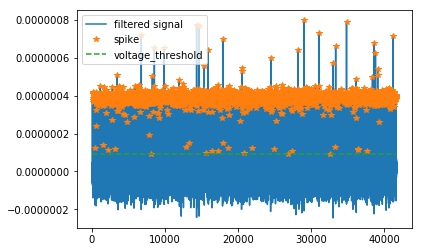

2348
Detect peaks with amplitude threshold.
Voltage amplitude threshold - 4.72850962417e-07


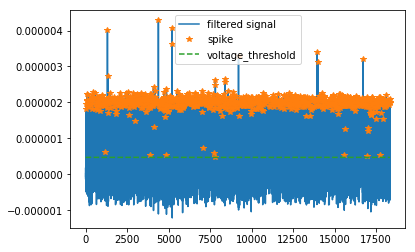

1018


In [5]:
spikes = spike_detection(data,sampling_interval, data.size)
print(len(spikes))

spikes_c = spike_detection(data_c,sampling_interval, data_c.size)
print(len(spikes_c))

In [9]:
def get_spike_features(spikes, data, sampling_interval, fs, plot_type):

    fig = plt.figure()
    ax = plt.subplot(111)
    num_samples_about_spike=int(refractory_period/sampling_interval)
    spike_num_samples=2*(num_samples_about_spike)+1
    print('Each spike has '+ str(spike_num_samples) + ' samples')
    
    spike_time=np.zeros((len(spikes),spike_num_samples))
    spike_data=np.zeros((len(spikes),spike_num_samples))
    
    cnt=0
    for l in spikes:

        T = sampling_interval
        nsamples = T * data.size

        t = np.linspace(0,nsamples,num=fs,endpoint=True)
        
        spike_time[cnt]=t[l-num_samples_about_spike:l+num_samples_about_spike+1]
        spike_data[cnt]=data[l-num_samples_about_spike:l+num_samples_about_spike+1].flatten()
        
        if(plot_type=='separate'):
            plt.plot(spike_time[cnt], spike_data[cnt], label='Spike-'+str(cnt))
            plt.plot(t[l], data[l], '*', label='spike')
            plt.show()
        elif(plot_type=='together'):
            time=t[0:spike_num_samples]
            plt.plot(time, spike_data[cnt], label='Spike-'+str(cnt))
            plt.show()
        cnt+=1
    return (spike_data,spike_time)

Each spike has 49 samples


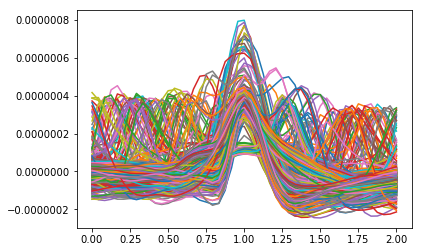

(2348, 49)


In [7]:
spike_data,spike_time = get_spike_features(spikes,data,sampling_interval, data.size, 'together')
print(spike_data.shape)
spike_df=pd.DataFrame(spike_data)

Each spike has 49 samples


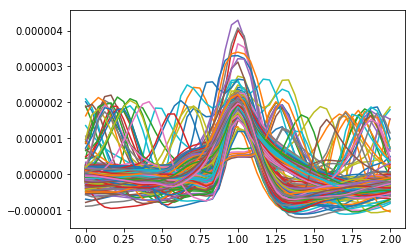

(1018, 49)


In [8]:
spike_data_c,spike_time_c = get_spike_features(spikes_c,data_c,sampling_interval, data_c.size, 'together')
print(spike_data_c.shape)
spike_df_c=pd.DataFrame(spike_data_c)

In [10]:
'''
Combine the 2 spike information
'''
print(spike_df.shape,spike_df_c.shape)
spike_df_temp=spike_df

spike_df = pd.concat([spike_df,spike_df_c])
print(spike_df.shape)

(2348, 49) (1018, 49)
(3366, 49)


In [11]:
def dim_redn(dataframe, method):
    
    if( method == 'PCA' ):
        from sklearn.decomposition import PCA
        pca = PCA(n_components=3, whiten=True)
        low_dim_data = pca.fit_transform(dataframe.values)

    elif( method == 'LPP' ):
        from lpproj import LocalityPreservingProjection
        lpp = LocalityPreservingProjection(n_components=3)
        low_dim_data = lpp.fit_transform(dataframe.values)
        
    print(low_dim_data.shape)
    low_dim_df=pd.DataFrame(low_dim_data)
        
    m,n = low_dim_data.shape
    idx=np.linspace(0,m-1,m)

    for i in range(n):
            plt.plot(idx, low_dim_df.loc[:,i], label='PC-' + str(i+1))
    plt.legend(loc='best')
    plt.show()
    
    
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for i in range(m):
        j=0
        while (j+1 < n):
            ax.scatter(low_dim_df.loc[i,j], low_dim_df.loc[i,j+1], c='r', marker='o')
            j+=2

    ax.set_xlabel('PC-1')
    ax.set_ylabel('PC-2')
    ax.set_zlabel('PC-3')
    plt.show()
    
    return low_dim_df

PCA RESULTS
(3366, 3)


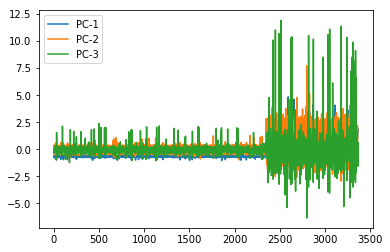

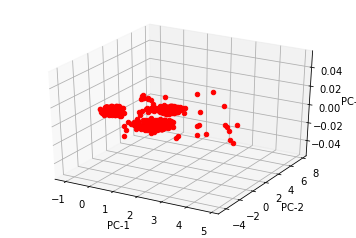

LPP RESULTS
(3366, 3)


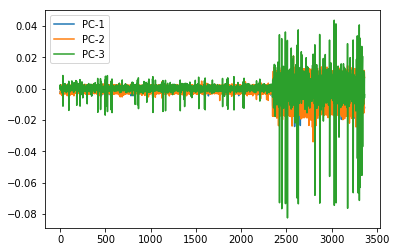

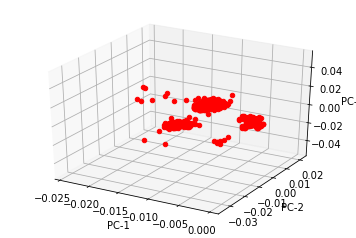

In [12]:
print('PCA RESULTS')
input_df=dim_redn(spike_df,'PCA')
print('LPP RESULTS')
input_df_1=dim_redn(spike_df,'LPP')


In [15]:
def gmm(df):
    max_neurons=20
    num_clusters=min(max_neurons,len(df))
    max_components = np.arange(1, num_clusters+1, 1)

    from sklearn.mixture import GaussianMixture
    models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(df)
              for n in max_components]

    idx=0
    bic_val = np.zeros(num_clusters)
    aic_val = np.zeros(num_clusters)
    for m in models:
        bic_val[idx]=m.bic(df)
        aic_val[idx]=m.aic(df)
        idx+=1

    plt.figure()
    plt.plot(max_components, bic_val, label='BIC')
    plt.plot(max_components, aic_val, label='AIC')  
    plt.legend(loc='best')
    plt.xlabel('max_components');
    plt.show()
    
    b=np.argmin(bic_val)
    a=np.argmin(aic_val)
    
    X = df
    gmm = GaussianMixture(3, covariance_type='full', random_state=0)
    labels = gmm.fit(X).predict(X)
    import collections
    counter=collections.Counter(labels)
    print(counter)
    
    # define the colormap
    cmap = plt.cm.jet
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # create the new map
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    color=['r','g','b','y','c','m', 'y', 'k']
    for i in range(X.shape[0]):
        ax.scatter(X.loc[i,0], X.loc[i,1], X.loc[i,2], c=color[labels[i]], s=40, marker='o')
    ax.set_xlabel('PC-1')
    ax.set_ylabel('PC-2')
    ax.set_zlabel('PC-3')
    plt.show()

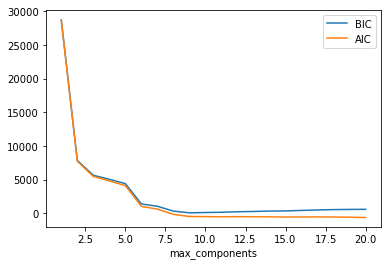

Counter({1: 2198, 2: 617, 0: 551})


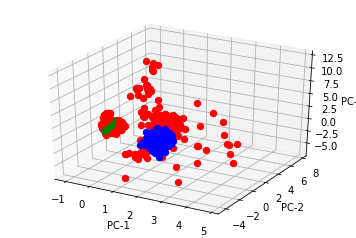

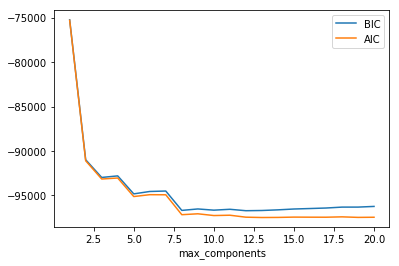

Counter({2: 2316, 0: 625, 1: 425})


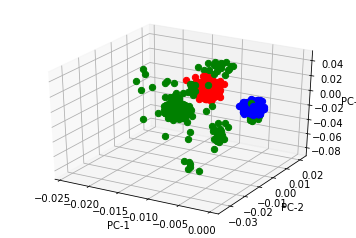

In [16]:
gmm(input_df)
gmm(input_df_1)

In [27]:
def kmeans(df,k):
    from sklearn.cluster import KMeans
    labels = KMeans(n_clusters=k, random_state=0).fit(df).labels_
    import collections
    counter=collections.Counter(labels)
    print(counter)

    X = df
    # define the colormap
    cmap = plt.cm.jet
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # create the new map
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
        
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    color=['r','g','b','y','c','m', 'y', 'k']
    for i in range(X.shape[0]):
        ax.scatter(X.loc[i,0], X.loc[i,1], X.loc[i,2], c=color[labels[i]], s=40, marker='o')
    ax.set_xlabel('PC-1')
    ax.set_ylabel('PC-2')
    ax.set_zlabel('PC-3')
    plt.show()
    return labels

Counter({1: 2351, 2: 664, 0: 351})


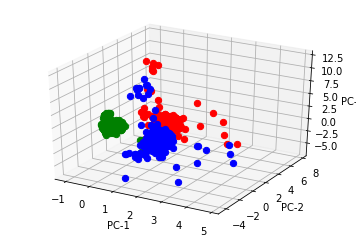

Counter({0: 3003, 1: 344, 2: 19})


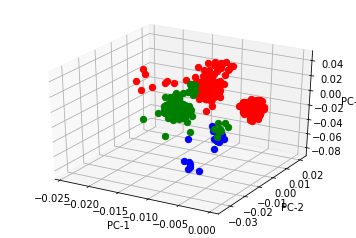

In [28]:
km_labels = kmeans(input_df,3)
km_labels_1 = kmeans(input_df_1,3)

In [25]:
# Function to find reciprocal of Degree matrix (D^-1)
def diag_neg( D ):
    diag_elems = np.nan_to_num( np.diagonal( D ) )
    return np.diag( np.nan_to_num( np.reciprocal( diag_elems ) ) )

# Function to find reciprocal of root of Degree matrix (D^-0.5)
def diag_neg_root( D ):
    D_root = np.sqrt( D )
    D_neg_root = diag_neg( D_root )
    return D_neg_root

# Function to find the kernel weights between 2 vectors x and u
def gaussian_kernel( x, u ):
    h = 1
    norm = np.linalg.norm(x - u)
    return np.exp(-(norm**2)/(2*(h**2)))

# Link to Landmark Based Spectral Clustering Paper : https://www.cs.cmu.edu/~xinleic/papers/aaai11.pdf
def landmark_based_SC( X, k ):
    
    p = int( np.sqrt( X.shape[0] ) )
    
    # Matrix X can be viewed as 'n' data points, each of dimension 'm'
    m,n = X.shape

    # If in Sparse COO matrix convert to array
    # X = X.toarray()
            
    # Choose p points/indices without repetition from [0,n)
    U_idx = np.random.choice( range(n), p, replace=False )

    # Fill those p randomly chosen points from matrix X into U
    U = np.zeros((m,p))
    for i in range(p):
         U[:,i] = X[:,U_idx[i]]
    print(U.shape)
    
    
    # Number of nearest landmark points from the 'p' points of U that we need to
    # consider for calculating U_r
    r = int(p/5)
    xi = np.zeros((m,1))
    Z = np.zeros((p,n))
            
    for i in range(n):
                
        # xi indicates every datapoint of matrix
        xi[:,0] = X[:,i]
                
        # U_r_idx populates xi's 'r' nearest vector's(datapoints) indices in U
        from scipy import spatial
        tree = spatial.KDTree(np.transpose(U))
        U_r_idx = (tree.query(np.transpose(xi),k=r)[1]).flatten()
        
        # Z_list stores gaussian kernel weights between xi and 'r' nearest
        # neighbours to xi in the matrix U
        # Nadraya Watson Kernel Regression
        Z_list = np.zeros(U_r_idx.size)
        ctr=0
        for j in U_r_idx:
            Z_list[ctr] = gaussian_kernel( xi, U[:,j] )
            ctr+=1
        
        # Normalize and fill weights in Z matrix
        ctr=0
        if( sum( Z_list ) ):
            for j in U_r_idx:
                Z[j,i] = Z_list[ctr]/sum(Z_list)
                ctr+=1


    assert( np.isnan(Z).any() == False )
    
    D = np.diag( np.ravel( np.sum( Z, axis=1 ) ) )
    D_neg_root = diag_neg_root( D )
    
    # Compute Z_hat = D^-0.5 * Z
    Z_hat = np.dot( D_neg_root, Z )

    # SVD of Z_hat gives B_tran
    A, S, B_tran = np.linalg.svd( Z_hat, full_matrices=False )
    B = np.transpose( B_tran )

    # What B has right now would be the eigenvectors of (Z_hat * Z_hat.T)
    
    from sklearn.cluster import KMeans
    labels = KMeans(n_clusters=k, random_state=0).fit(B[:,0:k]).labels_
    return labels

(3366, 49)
(49, 7)
Counter({1: 2772, 0: 464, 2: 130})
(3366, 3)


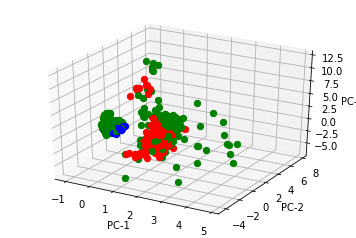

(3366, 3)


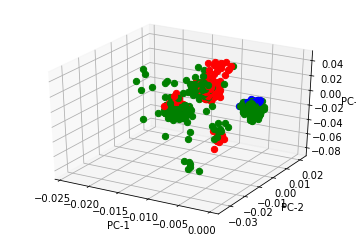

In [26]:
graph = spike_df.as_matrix()
print(graph.shape)

labels = landmark_based_SC( graph.T, 3 )

import collections
counter=collections.Counter(labels)
print(counter)

for method in ['PCA','LPP']:
    if( method == 'PCA' ):
        from sklearn.decomposition import PCA
        pca = PCA(n_components=3, whiten=True)
        low_dim_data = pca.fit_transform(graph)

    elif( method == 'LPP' ):
        from lpproj import LocalityPreservingProjection
        lpp = LocalityPreservingProjection(n_components=3)
        low_dim_data = lpp.fit_transform(graph)

    X = pd.DataFrame(low_dim_data)
    print(X.shape)
    # define the colormap
    cmap = plt.cm.jet
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # create the new map
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    color=['r','g','b','y','c','m', 'y', 'k']
    for i in range(X.shape[0]):
        ax.scatter(X.loc[i,0], X.loc[i,1], X.loc[i,2], c=color[labels[i]], s=40, marker='o')
    ax.set_xlabel('PC-1')
    ax.set_ylabel('PC-2')
    ax.set_zlabel('PC-3')
    plt.show()